# Examples

## Altitude Control of a Quadcopter

Imagine you have a quadcopter and you want the drone to hover at a certain altitude. The equations governing the relationship between thrust and altitude is given as the following:

$$ \ddot{z} = g - (\cos{\phi}\cos{\theta})\cdot\frac{u}{m} $$

Where *g* is the gravity, *u* is the thrust provided by the rotors and *m* is the mass of the quadcopter. Considering a perfectly horizontal quadcopter, pitch and roll are zero, and the equation reduces to:

$$ \ddot{z} = g - \frac{u}{m} $$

In [2]:
%matplotlib inline

import numpy as np
import pyadrc
import matplotlib.pyplot as plt
from scipy import signal

plt.rcParams['figure.figsize'] = [10, 7.5]

### Creating QuadAltitude

There are three variables, which initialize the mass of the quadcopter, the gravity and the sampling time.

You can leave the default setting in, or change it up to see how your controller performs under different settings.

Our quadcopter has a mass of 28 grams, the gravity acceleration is $9.807m/s^2$ and the sampling time is 1ms.

In [3]:
quad = pyadrc.QuadAltitude(dt=0.001, m=0.028, g=9.807)

### Creating StateSpace ADRC

If you already looked at Section **Introduction**, you already have a pretty good idea of how you should tune your ADRC. But, just in case, we'll go step-by-step:

When you create StateSpace ADRC, you need to pass the following arguments:

* **Order**
  * either first-order or second-order depending on the plant
* **Sampling time** $\Delta$
* **Modelling parameter** $b_0$
  * Check out the introduction to learn more about this parameter.
* **Settling time** $t_{settle}$
  * This is the approximate time it takes for the system output to reach the 5%-band of the reference signal, this property is fulfilled only for a perfect modelling parameter.
  * Places the controller poles and determines closed-loop bandwidth
* $k_{ESO}$
  * Places the observer poles, such that observer poles are k-times faster than the controller poles.

### Designing the control loop

Both classes have __call__() method implemented, which means in order to interact with the objects, you just call the actual object. For more information please refer to the API.

First, we send the first signal to the quadcopter, read the output of the drone, feed it to our controller along with the previous control signal, the reference signal (also called a setpoint). ADRC returns a control signal which is, again, the input signal of the plant. 

The boolean variable *zoh* implements a zero-order hold, which holds the current input constant as long as the next sampling instant has not been reached. For actual implementations, it should be True. For simulations, False is perfectly acceptable.

In [4]:
# Create StateSpace with parameters, define sampling time
delta = 0.001
adrc = pyadrc.StateSpace(order=2, delta=delta,
                         b0=1/0.028, t_settle=0.5, k_eso=10)

The controller we are designing is second-order with a modelling parameter $b_0$ of 1/0.028. The settling time is 500ms and the observer poles are 10 times faster than controller poles. The control loop is sampled with 1000Hz (i.e. sampling time is 1ms).

Lets select a reference altitude of 0.5 meters, after one second the new reference will be 1 meters. In total, we will simulate 2 seconds to observe the steady-state mode.

### Modelling parameter $b_0$ - optimally tuned

Lets see what happens if $b_0$ is tuned to the optimal value, $b_0 = \dfrac{1}{0.028}$

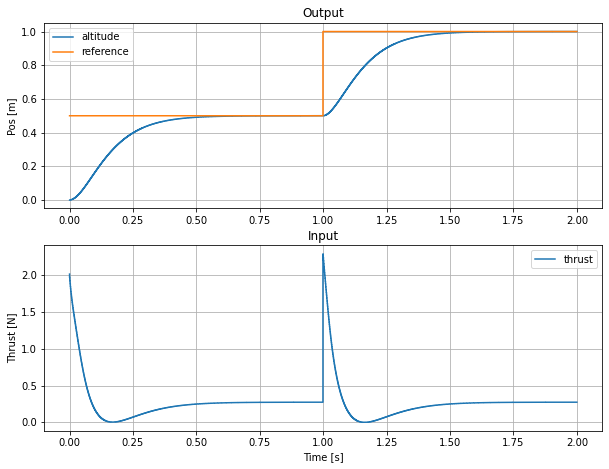

In [5]:
# Example of a control loop

u = 0  # First signal
r_1 = 0.5  # Reference 1 = 50cm
r_2 = 1.  # Reference 2 = 1m
counter =  0.
sample = 1000 * 2  # Sampling points = 1000Hz * 2 seconds
_u, _y, _setpoint = [], [], []

r = r_1  # Set first reference to Reference 1

while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, zoh=False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

# Create time vector
t = np.linspace(0, delta*sample, sample+1)

# Plot signals
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.title('Input')
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()

Following observations can be made:

  * The characteristic overshoot and oscillation of a second-order system cannot be detected.
  * Settling time perfectly matches the desired closed-loop dynamics.

This is an immediate effect of selecting a perfect modelling parameter $b_0$. However, in most cases, like when a PID controller is used, you have no prior knowledge of the internal model of the plant. 

### Modelling parameter $b_0$ - sub-optimally tuned

Lets assume something went horribly wrong during tuning and we have chosen a modelling parameter that is 50% off of the actual value, i.e. $b_0 = 1/0.028/2$.

In [6]:
adrc = pyadrc.StateSpace(order=2, delta=delta,
                         b0=1/0.028/2, t_settle=0.5, k_eso=10)

In [1]:
quad = pyadrc.QuadAltitude(dt=0.001, m=0.028, g=9.807)

u = 0
r_1 = 0.5
r_2 = 1.
counter =  0.
sample = 1000 * 2
_u, _y, _setpoint = [], [], []

r = r_1

while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

t = np.linspace(0, delta*sample, sample+1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output - zoomed')
plt.xlim([0.95, 1.75])
plt.ylim([0.4, 1.2])
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.title('Input - zoomed')
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.xlim([0.95, 1.75])
plt.ylim([-1, 5])
plt.grid()

SyntaxError: invalid syntax (<ipython-input-1-e4de4298ec5f>, line 1)

The desired closed-loop dynamics (i.e. settling time of 500 ms) is still achieved, but due to the imperfect modelling parameter, the closed-loop displays some oscillations. 

However, even with a suboptimal modelling parameter, ADRC works surprisingly well:

  * The desired closed-loop dynamics are achieved.
  * After ESO converged overshoot cannot be detected.

ESO *learned* the plant it is observing.

### Disturbance rejection

Disturbance rejection is what ADRC is famous for, it is literally in the name! It is important to note that, ADRC does not differentiate between different types of disturbances, it lumps them all in one state, and decouples it from the system. Lets use a suboptimal modelling parameter.

We will simulate one constant disturbance, which pushes down on the quadcopter, which would normally cause it to go down about 50 cm. After 1 second of this disturbance, we will implement another disturbance, which causes the motor to malfunction, i.e. thrust will have a sinusodial disturbance.

Experiment:

  * Suboptimal modelling parameter $b_0=1/0.028/2$
  * Constant reference signal r(k) = 0.5.
  * First disturbance source at time = 1s: Output disturbance, drone will be pushed down, constant displacement of -50 cm.
  * Second disturbance source at time = 2s: Input disturbance, motor malfunction, sinusodial disturbance
  * Second-order, sampling rate is 1000Hz, settling time is 0.5s, $k_{ESO}=10$, 

In [8]:
adrc = pyadrc.StateSpace(order=2, delta=delta, b0=1/0.028/2, t_settle=0.5, k_eso=10)

In [9]:
quad = pyadrc.QuadAltitude(dt=0.001, m=0.028, g=9.807)

u = 0.
counter =  0
wave_counter = 0
sample = 1000 * 5
_u, _y, _setpoint = [], [], []

r = 0.5

t = np.linspace(0, delta*sample, sample+1)
w = np.linspace(-4*np.pi, 4*np.pi, sample+1)
wave = np.sin(w)*2

while counter <= sample:
    y = quad(u)
    
    if counter >= 1000:
        y -= 0.1
    
    u = adrc(y, u, r, False)
    
    if counter >= 2000:
        u += wave[wave_counter]
        wave_counter += 1
    
    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1

"\nplt.figure()\nplt.plot(t, wave, ds='steps', label='thrust')\nplt.legend()\nplt.title('Input - zoomed')\nplt.ylabel('Thrust [N]')\nplt.xlabel('Time [s]')\nplt.xlim([2, 5])\nplt.ylim([-1.5, 1.5])\nplt.grid()"

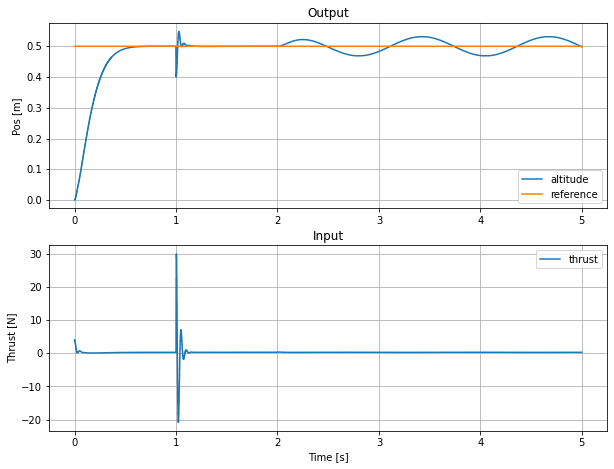

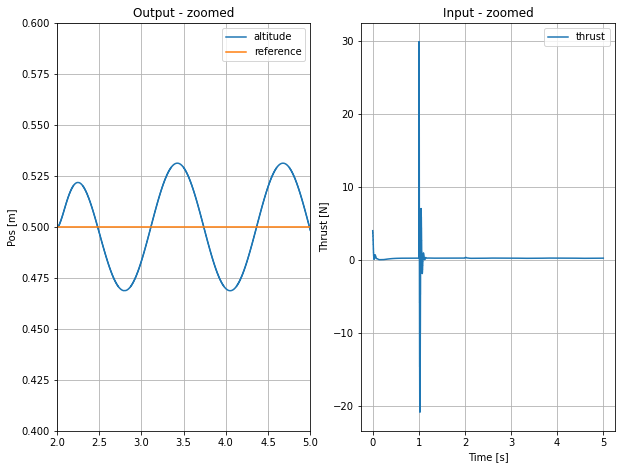

In [10]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.title('Input')
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output - zoomed')
plt.xlim([2, 5])
plt.ylim([0.4, 0.6])
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.title('Input - zoomed')
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
#plt.xlim([2, 5])
#plt.ylim([-2.5, 2.5])
plt.grid()

"""
plt.figure()
plt.plot(t, wave, ds='steps', label='thrust')
plt.legend()
plt.title('Input - zoomed')
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.xlim([2, 5])
plt.ylim([-1.5, 1.5])
plt.grid()"""

In [11]:
adrc = pyadrc.StateSpace(order=2, delta=delta, b0=1/0.028, t_settle=1, k_eso=10)

adrc.magnitude_limits = (-5, None)

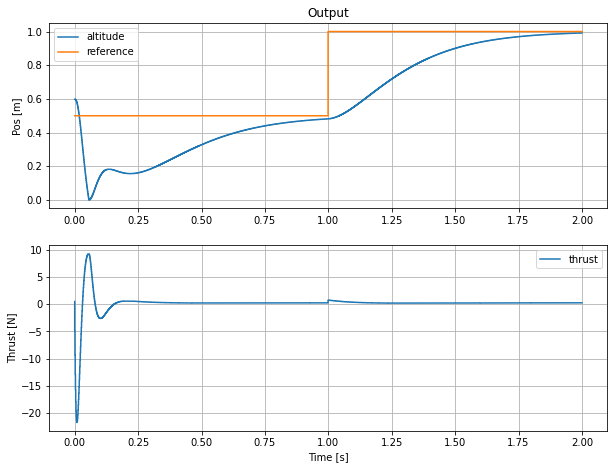

In [12]:
u = 0
r_1 = 0.5
r_2 = 1.
counter =  0.
sample = 1000 * 2
_u, _y, _setpoint = [], [], []

r = r_1

while counter <= sample:
    y = quad(u)
    u = adrc(y, u, r, False)

    _y.append(y)
    _u.append(u)
    _setpoint.append(r)

    counter = counter + 1
    
    if counter == 1000:
        r = r_2

t = np.linspace(0, delta*sample, sample+1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, _y, ds='steps', label='altitude')
plt.plot(t, _setpoint, ds='steps', label='reference')
plt.ylabel('Pos [m]')
plt.title('Output')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, _u, ds='steps', label='thrust')
plt.legend()
plt.ylabel('Thrust [N]')
plt.xlabel('Time [s]')
plt.grid()